In [1]:
include("common.jl")

using Callbacks
using InvRayTrace: img, img_obs, nointersect, scene
using InvRayTrace: Vec3, Sphere
import InvRayTrace
import RayTrace
import ImageView
using Lens
using Omega
using Omega.Space
using CanSee
using Images
using Plots

"Generate 500 samples using inverse graphics"
generatedata() = InvRayTrace.sampleposterior_noi(500; noi = false, alg = SSMH, gamma = 100.0);

"High resolution render of scene"
highresrender(sc) = RayTrace.rgb.(RayTrace.render(sc; width = 1024, height = 1024));

┌ Info: Recompiling stale cache file /home/zenna/.julia/compiled/v1.1/InvRayTrace/JoQ7d.ji for InvRayTrace [8a45d79e-a589-11e8-1025-51d29e337d7e]
└ @ Base loading.jl:1184
Expr(:block, #= Symbol("/home/zenna/repos/Omega.jl/src/lift/lift.jl"):7 =#, Expr(:function, Expr(:call, :nointersect, Expr(:::, :x1, Expr(:., :Omega, :(:RandVar)))), Expr(:block, #= Symbol("/home/zenna/repos/Omega.jl/src/lift/lift.jl"):8 =#, Expr(:call, Expr(:., :Omega, :(:ciid)), :nointersect, Expr(:::, :x1, Expr(:., :Omega, :(:RandVar)))))))
  ** incremental compilation may be broken for this module **

Expr(:block, #= Symbol("/home/zenna/repos/Omega.jl/src/lift/lift.jl"):7 =#, Expr(:function, Expr(:call, :isequidistant, Expr(:::, :x1, Expr(:., :Omega, :(:RandVar)))), Expr(:block, #= Symbol("/home/zenna/repos/Omega.jl/src/lift/lift.jl"):8 =#, Expr(:call, Expr(:., :Omega, :(:ciid)), :isequidistant, Expr(:::, :x1, Expr(:., :Omega, :(:RandVar)))))))
  ** incremental compilation may be broken for this module **

┌ Info:

### Actual Causation
In this example we use counterfactuals to determine whether a is the cause of b.
In particular, to determine whether the position of some object a is the cause of us not being able to see object b
We will solve two problems
1. Inverse Graphics, figure out what hte 3d scene is that created a 2d image
2. The actual causation question described above

In principle we could do these simultaneously as one big inference query but to save computation time here we will solve the 1 first and use that data data in the second

### 1. Inverse Graphics

Sample from the posterior of scenes

In [2]:
samples = generatedata()

500-element Array{RayTrace.ListScene{RayTrace.MaterialGeom{GeometryTypes.HyperSphere{3,Float64},RayTrace.Material{GeometryTypes.Vec{3,Float64},Float64,Float64,GeometryTypes.Vec{3,Float64}}}},1}:
 RayTrace.ListScene{RayTrace.MaterialGeom{GeometryTypes.HyperSphere{3,Float64},RayTrace.Material{GeometryTypes.Vec{3,Float64},Float64,Float64,GeometryTypes.Vec{3,Float64}}}}(RayTrace.MaterialGeom{GeometryTypes.HyperSphere{3,Float64},RayTrace.Material{GeometryTypes.Vec{3,Float64},Float64,Float64,GeometryTypes.Vec{3,Float64}}}[MaterialGeom{HyperSphere{3,Float64},Material{Vec{3,Float64},Float64,Float64,Vec{3,Float64}}}(HyperSphere{3,Float64}([0.69324, -0.162702, -15.839], 2.12108), Material{Vec{3,Float64},Float64,Float64,Vec{3,Float64}}([0.285433, 0.815279, 0.0264577], 1.0, 0.0, [0.0, 0.0, 0.0])), MaterialGeom{HyperSphere{3,Float64},Material{Vec{3,Float64},Float64,Float64,Vec{3,Float64}}}(HyperSphere{3,Float64}([5.70362, 0.170901, -13.1151], 2.39655), Material{Vec{3,Float64},Float64,Float64,Vec{3,

Visualize a single sample from the posterior

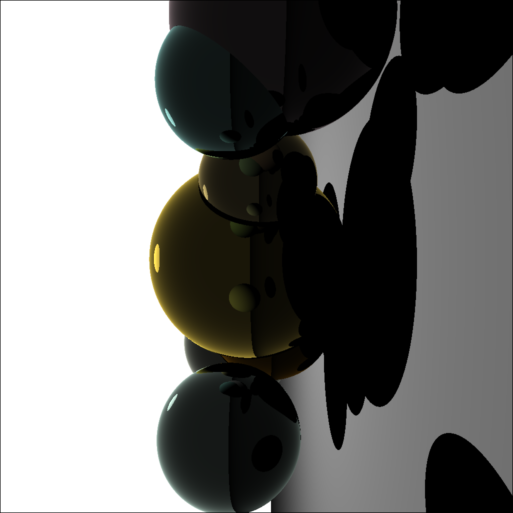

In [3]:
scene_sample = samples[end]
highresrender(scene_sample)

From a copy of the scene take a single object, Remove object with id gid from scene

In [4]:
scene_sample2 = deepcopy(scene_sample)
gid = 1

1

Create a new scene `scene_sample3` which has object which has the gid'th object removed

In [5]:
scene_sample3 = RayTrace.ListScene([g for (i, g) in enumerate(scene_sample2.geoms) if i!=gid])
k = scene_sample.geoms[gid];

We will add a white ball into the scene inside of k

Define the material colour white

In [6]:
white = RayTrace.Material(Vec3(1.0, 1.0, 0.0), 0.5, 0.0, Vec3(0.0, 0.0, 0.0));

Create a new white sphere `objb` at position of `k` but a fraction `frac` of the size

In [7]:
frac = 0.8
objb = RayTrace.MaterialGeom(Sphere(k.center, k.r*frac), white)

RayTrace.MaterialGeom{GeometryTypes.HyperSphere{3,Float64},RayTrace.Material{GeometryTypes.Vec{3,Float64},Float64,Float64,GeometryTypes.Vec{3,Float64}}}(GeometryTypes.HyperSphere{3,Float64}([-2.69307, -0.0664584, -17.9878], 1.6968651860059993), RayTrace.Material{GeometryTypes.Vec{3,Float64},Float64,Float64,GeometryTypes.Vec{3,Float64}}([1.0, 1.0, 0.0], 0.5, 0.0, [0.0, 0.0, 0.0]))

Add the new sphere to the scene

In [8]:
push!(scene_sample2.geoms, objb)

11-element Array{RayTrace.MaterialGeom{GeometryTypes.HyperSphere{3,Float64},RayTrace.Material{GeometryTypes.Vec{3,Float64},Float64,Float64,GeometryTypes.Vec{3,Float64}}},1}:
 RayTrace.MaterialGeom{GeometryTypes.HyperSphere{3,Float64},RayTrace.Material{GeometryTypes.Vec{3,Float64},Float64,Float64,GeometryTypes.Vec{3,Float64}}}(GeometryTypes.HyperSphere{3,Float64}([-2.69307, -0.0664584, -17.9878], 2.121081482507499), RayTrace.Material{GeometryTypes.Vec{3,Float64},Float64,Float64,GeometryTypes.Vec{3,Float64}}([0.911954, 0.815279, 0.504086], 1.0, 0.0, [0.0, 0.0, 0.0]))
 RayTrace.MaterialGeom{GeometryTypes.HyperSphere{3,Float64},RayTrace.Material{GeometryTypes.Vec{3,Float64},Float64,Float64,GeometryTypes.Vec{3,Float64}}}(GeometryTypes.HyperSphere{3,Float64}([4.68839, 0.697801, -13.1151], 1.862595194606893), RayTrace.Material{GeometryTypes.Vec{3,Float64},Float64,Float64,GeometryTypes.Vec{3,Float64}}([0.823098, 0.950623, 0.894988], 1.0, 0.0, [0.0, 0.0, 0.0]))   
 RayTrace.MaterialGeom{Geometr

Inspect which element of the scene are visible

The module [CanSee](https://github.com/uaianonsubmit/causalsource/blob/master/CanSee/src/CanSee.jl) defines the predicate `cansee(scene, obj)` which returns a (soft) Boolean over whether `obj` is visible in `scene`
It projects rays from the viewpoint of the observer and tests for each object whether there is a ray which hits it

In [9]:
"For each element in scene determine if it can be seen"
canseein(scene) = [Bool(CanSee.cansee(scene, scene.geoms[i])) for i = 1:length(scene.geoms)]
canseein(scene_sample2)

11-element Array{Bool,1}:
  true
  true
  true
  true
  true
 false
  true
  true
  true
 false
 false

### 2. Actual Causality

Is fact that object a is where it is,  reason we can't see object b?

In [10]:
objacenter = constant(k.center)
obja = ciid(ω -> RayTrace.MaterialGeom(Sphere(objacenter(ω), k.r), k.material))

sc = ciid(ω -> RayTrace.ListScene([[g for (i, g) in enumerate(scene_sample2.geoms) if i != gid] ; obja(ω)] ))
cantseeb = ciid(ω -> !CanSee.cansee(sc(ω), objb))

512:getfield(Main.##369, Symbol("##15#16"))()()::Any

Check is fact that in some world ω, is fact that obja where it is cause that we can't see object b

In [11]:
ω = defΩ()()

Omega.Space.LinearΩ{Array{Int64,1},UnitRange{Int64},Array{Any,1}}(Dict{Array{Int64,1},UnitRange{Int64}}(), Any[])

Now we will check for but-for cause.
This is defined in our extension of Omega [here](https://github.com/uaianonsubmit/causalsource/blob/master/Omega.jl/src/causal/causes.jl)

CanSee.iscausebf(ω, objacenter ==ₛ objacenter(ω), cantseeb, [objacenter];
                 sizes = [3],
                 proj = v -> Point(v[1], v[2], v[3]), init = () -> [k.center.data...])#-
*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*